# ROBERTA TRANSFORMER, BINARY AND MULTICLASS TASKS FOR CYBERBULLYING DETECTION

by ChunkDevs (Group 1)

Transformer are the standard architecture for building large language models, thanks to their mechanism called self-attention, allows to build contextual representations of a word’s meaning that
integrate information from surrounding words, helping the model learn how words
relate to each other over large spans of text

In this notebook we will try to implement one of the most common transformer encoder-only model: **RoBERTa**. 
We will  use `Roberta-base` for binary and classification tasks with the dataset with only english tweets. After drawing the learning/ accuracy curves, the models will be trained directly using all the dev-set, then the results will be shown and compared.  

In [1]:
import sys
import os

directory = os.getcwd().split(os.path.sep)
root_index = directory.index("V_HLT")
root_path = os.path.sep.join(directory[:root_index+1])

sys.path.append(root_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import torch
import random

from _chunkdevs.models import ModelHandler, ChunkDevs_Transformer, Build_Handle
from _chunkdevs.data_functions import *

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW


from transformers import get_linear_schedule_with_warmup

from IPython.display import display, HTML

2024-06-26 04:16:50.654413: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 04:16:50.699902: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 04:16:51.447716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# DATA LOADING

In [3]:
dev_path = os.path.join(root_path, "data", "processed", "english_tweets_dev_set.csv")
dev = pd.read_csv(dev_path, encoding="utf-8", skipinitialspace=True)

test_path = os.path.join(root_path, "data", "processed", "english_tweets_test_set.csv")
test = pd.read_csv(test_path, encoding="utf-8", skipinitialspace=True)

model_path = os.path.join(root_path, "outputs", "models")

## MAIN VARIABLES

Just like the other notebooks, the value of 42 for the `RANDOM_STATE` and 0.2 for `VAL_SIZE` have been chosen in order to guarantee the reproducibilty of the procedure.  

For the `BATCH_SIZE` variable, we opted for a value of 16 examples for batch, which allows to reduce the amount of data that are allocated in the memory and consequentially save resources. 

`LEARNING_RATE` and `EPS` are the hyperparameters that need to be specified for the training of the roberta model. We decided to choose the most common values that are usually used for define the learning process.

Considering the `EPOCHS` hyperparameter, it necessary to clarify that the number of the epochs has been selected after the representation of the learning and accuracy curves in order to avoid a possible overfitting situation 

In [4]:
RANDOM_STATE = 42
VAL_SIZE = 0.2
BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-5
EPS = 1e-8

labels_name_bin = ["not_cyberbullying", "cyberbullying"]
labels_name_multi = ["age", "ethnicity", "gender", "not_cyberbullying", "other_cyberbullying", "religion"]

For implementing the transformers, we decided to use our class `ChunkDevs_Transformer` from our library, which uses PyTorch module for building and training Transformer-based models (BERT , BERT-multilingual or RoBERTa) for text classification.

This are the attributes needed:

- `model_type` : The type of Transformer model ("bert", "bert_multilingual" or "roberta").
- `sequences_length` The maximum length of input sequences. We always used 128, whic is a very common value
- `classes` : The number of classes for classification. 2 for binary classification, 6 for multiclass
- `random_state`: The random seed for reproducibility. (We always used 42)
- `device` : The device to run the model on (CPU or GPU).

This are the method available:

- `set_seed`: Set seed for reproducibility across runs.
- `forward`: Forward pass of the model, this method has been used during the training.
- `train_model`: Train the Transformer model, using the **cross entropy loss** as loss criteria
- `evaluate_model`: Evaluate the Transformer model on validation.
- `predict`: Make predictions using the trained Transformer model.
- `save_results`: Save evaluation results (accuracy and classification report) to a file.
- `train_val_curves`: Draw the loss/ accurracy curves of the transformer


# BINARY TASK

## DATA SPLITTING AND LOADING  

Using the processed text in the dev set and the raw tweets in the test set.

Using an Hold-Out validation approach (80% TR - 20% VAL split on the DEV set)

In [5]:
X_dev_bin = dev['tweet_text_cleaned'].values
y_dev_bin = dev['cyberbullying_type_bin'].values
X_test_bin = test['tweet_text'].values
y_test_bin = test['cyberbullying_type_bin'].values

X_train, X_val, y_train, y_val = train_test_split(X_dev_bin, y_dev_bin, test_size=VAL_SIZE) 

In this phase, we initialize a pretrained `RoBerta-base` model using the `ChunkDevs_Tranformer` class of our library. This class defines the model, the pretrained tokenizer, the dropout (0.2) and the classifier with `nn.Linear` of the pyTorch library.

Secondly, the dataset has been prepared in order to have a tokenized and suitable input for the transformer.

After that, the Adam optimizer and the train scheduler are defined.

In [6]:
roberta = ChunkDevs_Transformer("roberta", sequences_length=128, classes=2, random_state=RANDOM_STATE)

build_train = Build_Handle(X_train, y_train, tokenizer=roberta.tokenizer)
build_val = Build_Handle(X_val, y_val, tokenizer=roberta.tokenizer)

dataloader_train = DataLoader(build_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(build_val, batch_size=BATCH_SIZE)

optimizer = AdamW(roberta.parameters(), lr=LEARNING_RATE, eps=EPS)
steps = len(dataloader_train) * 5
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=steps)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## PLOTTING LEARNING AND ACCURACY CURVES

In [7]:
plot_epochs = 5
plot_title = "Roberta train/val learning/accuracy curves"

PLOTTING:: 131440it [28:59, 75.54it/s]                                          0.94it/s]


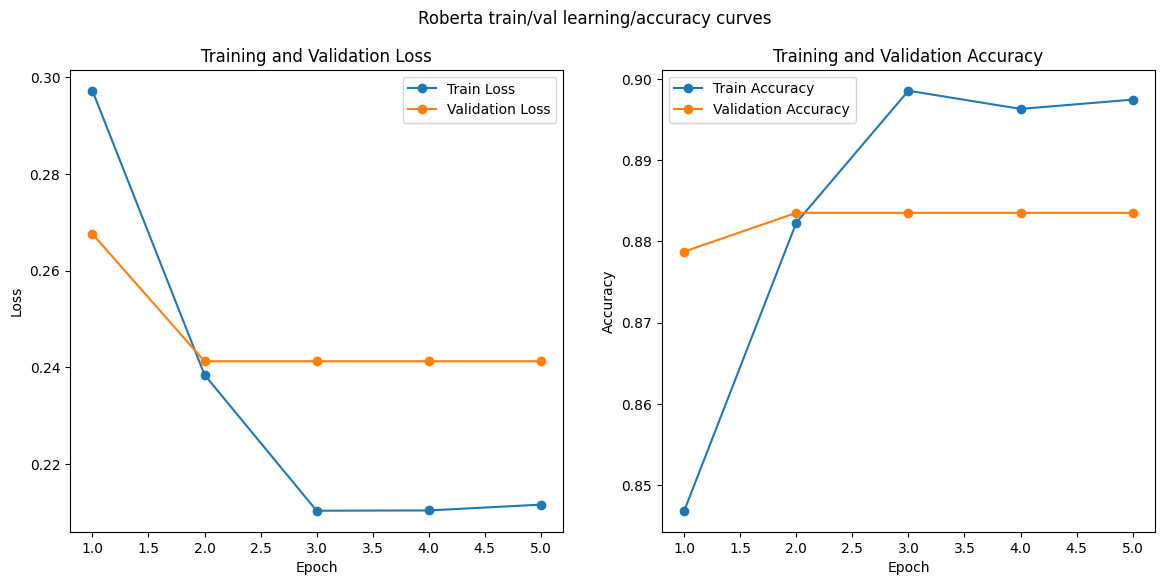

In [8]:
roberta.train_val_curves(train_dataloader=dataloader_train, val_dataloader=dataloader_val, optimizer=optimizer, scheduler=scheduler, plot_epochs=plot_epochs, title=plot_title)

<div style="font-size: 20px">

Looking at the plot, we can see that that the model **slightly overfits** in the second epoch. However, we still choosed 2 as the definitive number of epoch. A possible alternative would be to reduce the complexity of the model 

<br>
<br>
</div>

## FINAL RETRAIN AND TESTING PHASE

In this phase we initialize and train again the model using all the dev set in order to use all the available data, and then the model does a blind prediction on the test set with the `predict_model` and compares the final prediction with the test set label.

In [9]:
roberta = ChunkDevs_Transformer("roberta", sequences_length=128, classes=2, random_state=RANDOM_STATE)

build_dev = Build_Handle(X_dev_bin, y_dev_bin, tokenizer=roberta.tokenizer)
build_test = Build_Handle(X_test_bin, y_test_bin, tokenizer=roberta.tokenizer)

dataloader_dev = DataLoader(build_dev, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(build_test, batch_size=BATCH_SIZE)

optimizer = AdamW(roberta.parameters(), lr=LEARNING_RATE, eps=EPS)
steps = len(dataloader_dev) * 6
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=steps)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<div style="font-size: 16px;">
<br>
    
The `train__model` method implements the learning phase of the transformer, where the model calculates and returns the average loss for every epoch. 

The loss type that has been chosen is the *cross entropy* loss function:

$$ L_{CE}(\hat{y}, y) = -\log p(y|x) = -[y \log \hat{y} + (1 - y) \log (1 - \hat{y})] $$
Where $(y)$ is the true probability distribution and $(\hat{y})$ is our estimated distribution

</div>

In [10]:
roberta.train_model(dataloader=dataloader_dev, optimizer=optimizer, scheduler=scheduler, num_epochs=EPOCHS)

Training Epoch 1/2: : 26272it [06:41, 65.38it/s]                                                    4.36it/s]


Train Loss for Epoch 1: 0.2901


Training Epoch 2/2: : 26272it [06:43, 65.09it/s]                                                    6.27it/s]

Train Loss for Epoch 2: 0.2394
Trained Completed.


In [11]:
roberta_preds = roberta.predict(dataloader_test)
report = classification_report(y_test_bin, roberta_preds, target_names = labels_name_bin)
print(report)

PREDICTING:: 2928it [00:10, 270.36it/s]                                                             3.22it/s]

Prediction completed
                   precision    recall  f1-score   support

not_cyberbullying       0.52      0.78      0.63       487
    cyberbullying       0.95      0.86      0.90      2435

         accuracy                           0.85      2922
        macro avg       0.74      0.82      0.76      2922
     weighted avg       0.88      0.85      0.86      2922



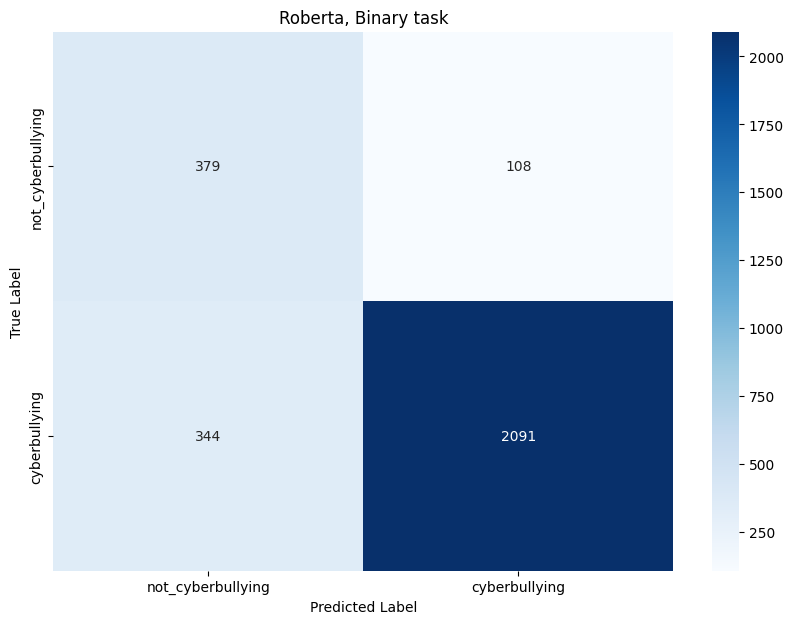

In [12]:
cm = confusion_matrix(y_test_bin, roberta_preds)

cm_df = pd.DataFrame(cm, index=labels_name_bin, columns=labels_name_bin)

# Visualizza la matrice di confusione usando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Roberta, Binary task')
plt.show()

<div style="font-size: 20px;">

As we can see from the results, this model tends to classify more tweets as not cyberbullying type than the other models, due to its **high recall value**. In other words, it is **less susceptible to the false flagging** phenomena, but it alloows more harmful messages to be considered as not cyberbullying acts

<br>

</div>


### SAVING THE MODEL AND THE RESULTS

In [13]:
report_path = os.path.join(root_path,  "outputs", "reports", "Roberta_binary_results")
roberta.save_results(dataloader_test, path = report_path, labels_name=labels_name_bin)

EVALUATION:: 2928it [00:06, 470.43it/s]                                                             8.21it/s]


--------------------------------------------------------------------------------
| Report saved to /home/m.sanna21/V_HLT/outputs/reports/Roberta_binary_results |
--------------------------------------------------------------------------------


In [14]:
handler = ModelHandler(model_path)
handler.save_model(model = roberta, name= "Roberta_binary")

------------------------------------------------------------------------------------------
| Save model 'Roberta_binary' to /home/m.sanna21/V_HLT/outputs/models/Roberta_binary.pkl |
------------------------------------------------------------------------------------------


# MULTI-CLASS TASK

In this phase the roberta model will be used for classyfying all the 6 classes and distinguish among the different cyberbullying types

## DATA LOADING  

In [15]:
X_dev_multi = dev['tweet_text_cleaned'].values
y_dev_multi = dev['cyberbullying_type_multi'].values
X_test_multi = test['tweet_text'].values
y_test_multi = test['cyberbullying_type_multi'].values

## FINAL RETRAIN AND TESTING PHASE

In [16]:
roberta = ChunkDevs_Transformer("roberta", sequences_length=128, classes=6, random_state=RANDOM_STATE)

build_dev = Build_Handle(X_dev_multi, y_dev_multi, tokenizer=roberta.tokenizer)
build_test = Build_Handle(X_test_multi, y_test_multi, tokenizer=roberta.tokenizer)

dataloader_dev = DataLoader(build_dev, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(build_test, batch_size=BATCH_SIZE)

optimizer = AdamW(roberta.parameters(), lr=LEARNING_RATE, eps=EPS)
steps = len(dataloader_dev) * 6
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=0, num_training_steps=steps)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
roberta.train_model(dataloader=dataloader_dev, optimizer=optimizer, scheduler=scheduler, num_epochs = EPOCHS)

Training Epoch 1/2: : 26272it [03:12, 136.67it/s]                                                   6.09it/s]


Train Loss for Epoch 1: 0.4876


Training Epoch 2/2: : 26272it [03:05, 141.43it/s]                                                   2.06it/s]

Train Loss for Epoch 2: 0.3283
Trained Completed.


In [18]:
roberta_preds = roberta.predict(dataloader_test)
report = classification_report(y_test_multi, roberta_preds, target_names= labels_name_multi)
print(report)

PREDICTING:: 2928it [00:07, 395.99it/s]                                                             9.50it/s]

Prediction completed
                     precision    recall  f1-score   support

                age       0.99      0.95      0.97       487
          ethnicity       0.97      0.97      0.97       487
             gender       0.91      0.85      0.88       487
  not_cyberbullying       0.67      0.60      0.63       487
other_cyberbullying       0.66      0.79      0.72       487
           religion       0.95      0.97      0.96       487

           accuracy                           0.86      2922
          macro avg       0.86      0.86      0.86      2922
       weighted avg       0.86      0.86      0.86      2922



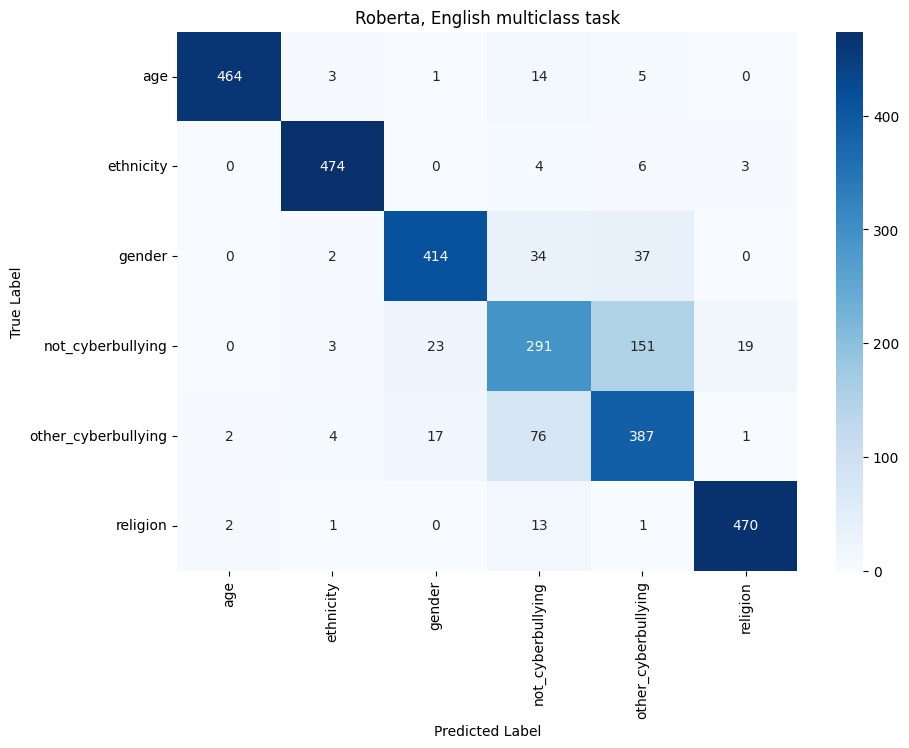

In [19]:
cm = confusion_matrix(y_test_multi, roberta_preds)

cm_df = pd.DataFrame(cm, index=labels_name_multi, columns=labels_name_multi)

# Visualizza la matrice di confusione usando Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Roberta, English multiclass task')
plt.show()

<div style="font-size: 20px;">

Looking at the results, Roberta is one of the models with the **highest accuracy** (86%), and it has the same weakness of the other models, confusing the not cyberbullying tweets with the other cyberbullying tweets

<br>

</div>

#### SAVING THE MODEL AND THE RESULTS

In [20]:
report_path = os.path.join(root_path, "V_HLT", "outputs", "reports", "Roberta_multiclass_results")
roberta.save_results(dataloader_test, path = report_path, labels_name=labels_name_multi)

EVALUATION:: 2928it [00:06, 471.01it/s]                                                             6.45it/s]

------------------------------------------------------------------------------------------
| Report saved to /home/m.sanna21/V_HLT/V_HLT/outputs/reports/Roberta_multiclass_results |
------------------------------------------------------------------------------------------


In [21]:
handler = ModelHandler(model_path)
handler.save_model(model = roberta, name= "Roberta_multiclass")

--------------------------------------------------------------------------------------------------
| Save model 'Roberta_multiclass' to /home/m.sanna21/V_HLT/outputs/models/Roberta_multiclass.pkl |
--------------------------------------------------------------------------------------------------
